In [1]:
import pandas as pd
import numpy as np
import re
import os
import nltk
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import json

from os.path import join
from sklearn.model_selection import StratifiedShuffleSplit
from fasttext import load_model
from tqdm import tqdm

#visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc

import random

## Разделение данных

In [2]:
def read_dataset(filepath, duplicates=False, clean=True):
    file = open(filepath, 'r', encoding='ISO-8859-1')
    data = pd.read_csv(file)

    old_names = data.keys()
    names = [n.encode('ISO-8859-1').decode('cp1251').encode('utf8') for n in old_names]
    names = [n.decode('utf-8') for n in names]

    new_data = dict()
    for old, new in zip(old_names, names):
        new_data[new] = list()
        for c in data[old]:
            try:
                s = c.encode('ISO-8859-1').decode('cp1251').encode('utf8')
                s = s.decode('utf-8')
                new_data[new].append(s)
            except AttributeError:
                new_data[new].append(c)

    new_data = pd.DataFrame(new_data, columns=['Описание', 'Категория жалобы'])
    new_data.rename(columns={'Описание': 'request', 'Категория жалобы': 'class'}, inplace=True)
    new_data = new_data.dropna()  # dell nan
    if not duplicates:
        new_data = new_data.drop_duplicates()  # dell duplicates

    # как отдельную ветвь можно использовать
    if clean:
        delete_bad_symbols = lambda x: " ".join(re.sub('[^а-яa-zё0-9]', ' ', x.lower()).split())
        new_data['request'] = new_data['request'].apply(delete_bad_symbols)

    new_data = new_data.reset_index()
    new_data = new_data.drop('index', axis=1)

    return new_data


path = '../data/vkusvill_all_categories.csv'
global_data = read_dataset(path)

/home/mks/intent/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [46]:
dd = dict()
cd = dict()

for x, y in zip(global_data['request'], global_data['class']):
    if y not in dd.keys():
        dd[y] = list()
        cd[y] = 0
        dd[y].append((x, y))
        cd[y] += 1
    else:
        dd[y].append((x, y))
        cd[y] += 1

# print(dd[1])
print(cd)

{1: 3288, 2: 5312, 3: 6791, 4: 1366, 5: 80, 6: 9600, 7: 3634, 8: 442, 9: 906, 10: 3501, 11: 2039, 12: 2287, 13: 3568, 14: 205, 15: 1188, 16: 922, 17: 42}


In [47]:
prop = [0.1, 0.1]

if type(prop) is list:
    assert len(prop) == 2
    assert type(prop[0]) is float

    valid_ = dict()
    test_ = dict()

    for x in dd.keys():
        num = int(cd[x]*prop[0])
        valid_[x] = random.sample(dd[x], num)
        [dd[x].remove(t) for t in valid_[x]]

    for x in dd.keys():
        num = int(cd[x]*prop[1])
        test_[x] = random.sample(dd[x], num)
        [dd[x].remove(t) for t in test_[x]]
else:
    raise ValueError('Split proportion must be list of floats, with length = 2')

train_ = dd

In [48]:
train, valid, test = list(), list(), list()


for x in train_.keys():
    for z_, z in zip([train_, valid_, test_], [train, valid, test]):
        z.extend(z_[x])

del train_, valid_, test_, dd

for z in [train, valid, test]:
    z = random.shuffle(z)

In [50]:
utrain, uvalid, utest, ctrain, cvalid, ctest = list(), list(), list(), list(), list(), list()

In [51]:
for z, n, c in zip([train, valid, test], [utrain, uvalid, utest], [ctrain, cvalid, ctest]):
    for x in z:
        n.append(x[0])
        c.append(x[1])

In [53]:
train = pd.DataFrame({'request': utrain,
                     'class': ctrain})
valid = pd.DataFrame({'request': uvalid,
                     'class': cvalid})
test = pd.DataFrame({'request': utest,
                     'class': ctest})

In [15]:
# test

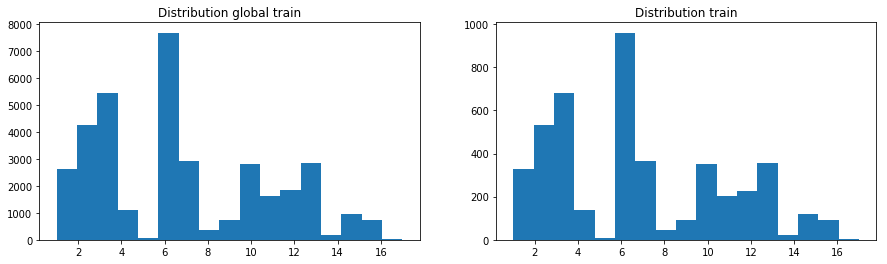

In [55]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

plt.subplot(1, 2, 1)
plt.title('Distribution global train')
plt.hist(train['class'], bins=17)  # 70

plt.subplot(1, 2, 2)
plt.title('Distribution train')
plt.hist(test['class'], bins=17)  # 70
plt.show()

## Отработка препроцессинга в классе pipeline

In [3]:
import random
import pandas as pd
from typing import Generator
from sklearn.model_selection import train_test_split


class Dataset(object):
    def __init__(self, data, seed=None, split=True, splitting_proportions=None,
                 *args, **kwargs):

        rs = random.getstate()
        random.seed(seed)
        self.random_state = random.getstate()
        random.setstate(rs)

        if splitting_proportions is None:
            self.splitting_proportions = [0.1, 0.1]
        else:
            self.splitting_proportions = splitting_proportions

        if not split:
            self.train = data.get('train', [])
            self.test = data.get('test', [])
            try:
                self.valid = data.get('valid', [])
                self.data = {'train': {'base': self.train},
                             'test': {'base': self.test},
                             'valid': {'base': self.valid},
                             'all': self.train + self.test}
            except KeyError:
                self.data = {'train': {'base': self.train},
                             'test': {'base': self.test},
                             'all': self.train + self.test}
        else:
            self.train, self.valid, self.test = self.split_data(data)
            self.data = {'train': {'base': self.train},
                         'test': {'base': self.test},
                         'valid': {'base': self.valid},
                         'all': self.train + self.test}

        self.data['classes'] = data['class'].unique()  # np.array

    def batch_generator(self, batch_size: int, data_type: str = 'train') -> Generator:
        r"""This function returns a generator, which serves for generation of raw (no preprocessing such as tokenization)
         batches
        Args:
            batch_size (int): number of samples in batch
            data_type (str): can be either 'train', 'test', or 'valid'
        Returns:
            batch_gen (Generator): a generator, that iterates through the part (defined by data_type) of the dataset
        """
        data = self.data[data_type]
        data_len = len(data)
        order = list(range(data_len))

        rs = random.getstate()
        random.setstate(self.random_state)
        random.shuffle(order)
        self.random_state = random.getstate()
        random.setstate(rs)

        # for i in range((data_len - 1) // batch_size + 1):
        #     yield list(zip(*[data[o] for o in order[i * batch_size:(i + 1) * batch_size]]))
        for i in range((data_len - 1) // batch_size + 1):
            o = order[i * batch_size:(i + 1) * batch_size]
            yield list((list(data['request'][o]), list(data['class'][o])))

    def iter_all(self, data_type: str = 'train') -> Generator:
        """
        Iterate through all data. It can be used for building dictionary or
        Args:
            data_type (str): can be either 'train', 'test', or 'valid'
        Returns:
            samples_gen: a generator, that iterates through the all samples in the selected data type of the dataset
        """
        data = self.data[data_type]
        for x, y in zip(data['request'], data['class']):
            yield (x, y)

    def _split_data(self, splitting_proportions, field_to_split, splitted_fields):
        data_to_div = self.data[field_to_split].copy()
        data_size = len(self.data[field_to_split])
        for i in range(len(splitted_fields) - 1):
            self.data[splitted_fields[i]], data_to_div = train_test_split(data_to_div,
                                                                          test_size=
                                                                          len(data_to_div) -
                                                                          int(data_size * splitting_proportions[i]))
        self.data[splitted_fields[-1]] = data_to_div
        return True

    def split_data(self, dataset):

        dd = dict()
        cd = dict()
        train = list()
        valid = list()
        test = list()

        for x, y in zip(dataset['request'], dataset['class']):
            if y not in dd.keys():
                dd[y] = list()
                cd[y] = 0
                dd[y].append((x, y))
                cd[y] += 1
            else:
                dd[y].append((x, y))
                cd[y] += 1

        if type(self.splitting_proportions) is list:
            assert len(self.splitting_proportions) == 2
            assert type(self.splitting_proportions[0]) is float

            valid_ = dict()
            test_ = dict()

            for x in dd.keys():
                num = int(cd[x] * self.splitting_proportions[0])
                valid_[x] = random.sample(dd[x], num)
                [dd[x].remove(t) for t in valid_[x]]

            for x in dd.keys():
                num = int(cd[x] * self.splitting_proportions[1])
                test_[x] = random.sample(dd[x], num)
                [dd[x].remove(t) for t in test_[x]]
        else:
            raise ValueError('Split proportion must be list of floats, with length = 2')

        train_ = dd

        for x in train_.keys():
            for z_, z in zip([train_, valid_, test_], [train, valid, test]):
                z.extend(z_[x])

        del train_, valid_, test_, dd, cd, dataset  # really need ?

        for z in [train, valid, test]:
            z = random.shuffle(z)

        utrain, uvalid, utest, ctrain, cvalid, ctest = list(), list(), list(), list(), list(), list()
        for z, n, c in zip([train, valid, test], [utrain, uvalid, utest], [ctrain, cvalid, ctest]):
            for x in z:
                n.append(x[0])
                c.append(x[1])

        train = pd.DataFrame({'request': utrain,
                              'class': ctrain})
        valid = pd.DataFrame({'request': uvalid,
                              'class': cvalid})
        test = pd.DataFrame({'request': utest,
                             'class': ctest})

        return train, valid, test

    def _merge_data(self, fields_to_merge):
        data = self.data.copy()
        new_name = [s + '_' for s in fields_to_merge]
        data[new_name] = []
        for name in fields_to_merge:
            data[new_name] += self.data[name]
        self.data = data
        return True


In [4]:
path = '../data/vkusvill_all_categories.csv'
global_data = read_dataset(path)

dataset = Dataset(global_data, seed=42)

/home/mks/intent/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Cleaning

In [127]:
config = {'nan': True, 'repeat': True}
def clean(data):
    if config['nan']:
        data = data.dropna()
    if config['repeat']:
        data = data.drop_duplicates()
    return data

for x in ['train', 'valid', 'test']:
    dataset.data[x]['base'] = clean(dataset.data[x]['base'])

In [128]:
print(dataset.data['classes'])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


### Transformation 

In [6]:
def transform(data, lower=True, lemma=True, ngramm=False):
    Tokens = list()
    for x in tqdm(data['request']):
        sent_toks = nltk.sent_tokenize(x)
        word_toks = [nltk.word_tokenize(el) for el in sent_toks]
        tokens = [val for sublist in word_toks for val in sublist]
        tokens = [el for el in tokens if el != '']
        if lower:
            tokens = [el.lower() for el in tokens]
        if lemma:
            tokens = [morph.parse(el)[0].normal_form for el in tokens]
        if ngramm:
            bigram = list(nltk.bigrams(tokens))
            bigram = ['_'.join(x) for x in bigram]
            tokens.extend(bigram)

        Tokens.append(' '.join(tokens))
    
    df = pd.DataFrame({'request': Tokens,
                       'class': data['class']})
    return df

In [8]:
dataset.data['test']['mod1'] = transform(dataset.data['test']['base'])

100%|██████████| 4510/4510 [00:30<00:00, 150.27it/s]


In [30]:
dataset.data['train']['mod1']['request'][0]
# b = list(nltk.bigrams(dataset.data['test']['base']['request'][0].split()))
# c = ['_'.join([x[0], x[1]]) for x in b]
# print(c)

'молоко цельный вечно горький молоко_цельный цельный_вечно вечно_горький'

### Vectorization

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from fasttext import load_model


In [12]:
cvec = CountVectorizer(min_df=5)
tfvec = TfidfVectorizer()
fast = load_model('/home/mks/projects/intent_classification_script/embeddings/ft_0.8.3_nltk_yalen_sg_300.bin')

In [10]:
# vec = cvec.fit_transform(dataset.data['test']['mod1']['request'])
# print(type(vec), vec)

In [11]:
# vec = tfvec.fit_transform(dataset.data['test']['mod1']['request'])
# print(type(vec), vec)

In [63]:
config = {'lemma': True,
          'lower': True,
          'n-gram': False,
          'vectorization': {'count': False,
                            'tf-idf': False,
                            'fasttext': True},
          'model': {'name': 'CNN', 'model_config': None},
          'fasttext_model': '/home/mks/projects/intent_classification_script/embeddings/ft_0.8.3_nltk_yalen_sg_300.bin'}

opt = {'text_size': 25, 'embedding_size': 300}

# vectorizers
if config['vectorization']['count']:
    vectorizer = CountVectorizer(min_df=5)  # tokenizer=self.tokenizer,
    config['tokenization'] = False
elif config['vectorization']['tf-idf']:
    vectorizer = TfidfVectorizer()  # tokenizer=self.tokenizer
    config['tokenization'] = False
elif config['vectorization']['fasttext']:
    vectorizer = load_model(config['fasttext_model'])
    config['tokenization'] = True
else:
    raise NotImplementedError('Not implemented vectorizer.')


def vectorization(data, train=False):
    # vectorization
    if not config['tokenization']:
        if train:
            vec = vectorizer.fit_transform(data)
        else:
            vec = vectorizer.transform(data)
    else:
        data = tokenize(data)
        if config['model']['name'] == 'CNN':
            vec = np.zeros((len(data), opt['text_size'], opt['embedding_size']))
            for j, x in enumerate(data):
                for i, y in enumerate(x):
                    if i < opt['text_size']:
                        vec[j, i] = vectorizer[y]
                    else:
                        break
        else:
            raise NotImplementedError()

    return vec

In [64]:
def tokenize(data):
    tok_data = list()
    for x in data:
        sent_toks = nltk.sent_tokenize(x)
        word_toks = [nltk.word_tokenize(el) for el in sent_toks]
        tokens = [val for sublist in word_toks for val in sublist]
        tok_data.append(tokens)
    
    return tok_data

In [65]:
vec = vectorization(dataset.data['test']['mod1']['request'], train=True)
print(type(vec))

<class 'numpy.ndarray'>


In [66]:
print(vec.shape)

(4510, 25, 300)


In [69]:
vec[0]

array([[-0.14035489, -0.13090529, -0.09723529, ...,  0.15279828,
        -0.01083812,  0.17575984],
       [ 0.261812  , -0.14000453, -0.20303327, ..., -0.05384609,
         0.23644029,  0.35637239],
       [-0.00729258,  0.06335171, -0.10834117, ...,  0.08143774,
        -0.0148092 ,  0.17577673],
       ...,
       [-0.16455102,  0.04506007, -0.01742407, ...,  0.00662705,
         0.09478074,  0.091369  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])